# Problema 3
Descripción:
En este problema, se proporciona un conjunto de datos que contiene imágenes de escenas naturales de todo el mundo. El objetivo es construir un modelo de clasificación utilizando redes neuronales convolucionales (CNN) para clasificar estas imágenes en una de las seis categorías predefinidas.


## Dataset:
https://drive.google.com/file/d/1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ/view?usp=drive_link

El dataset proporcionado contiene alrededor de 25,000 imágenes de tamaño 150x150, distribuidas en seis categorías:

- buildings
- forest
- glacier
- mountain
- sea
- street

Las imágenes están divididas en tres conjuntos:

- Train: Alrededor de 14,000 imágenes para entrenamiento.
- Test: Alrededor de 3,000 imágenes para evaluación del modelo.
- Prediction: Alrededor de 7,000 imágenes para predicción final.

## Objetivo:

Utilizando el dataset proporcionado, el objetivo es construir y comparar el rendimiento de distintos modelos de clasificación de imágenes utilizando redes neuronales convolucionales y densas que puedan clasificar con precisión las imágenes de escenas naturales en una de las seis categorías mencionadas anteriormente.
Los modelos a diseñar son:

- Modelo con capas densas.
- Modelo con capas convolucionales y densas.
- Modelo que incluya bloques residuales identidad
- Modelo que utilice como backbone alguna de las arquitecturas disponibles en TensorFlow (transfer learning): https://www.tensorflow.org/api_docs/python/tf/keras/applications

Se debe entrenar y evaluar cada modelo utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.


## Entrega:

La entrega debe incluir:

Código fuente de la solución implementada en Google Colab, que incluya:

- Análisis previo y preprocesamiento del set de datos.
- Definición y entrenamiento del modelo.
- Resultados de la evaluación del modelo, incluyendo métricas de desempeño y visualizaciones relevantes.

Nota: el código debe estar debidamente documentado con comentarios explicativos para que el trabajo sea fácilmente comprensible para otros revisores.


## Librerias

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2025-04-28 19:53:44.481628: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-04-28 19:53:50.189576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-28 19:53:50.248471: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-28 19:53:50.249202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
print("CUDA:", tf.sysconfig.get_build_info()["cuda_version"])
print("cuDNN:", tf.sysconfig.get_build_info()["cudnn_version"])

CUDA: 11.8
cuDNN: 8


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from pathlib import Path
from keras.layers import Input, RandomFlip, RandomContrast, BatchNormalization, RandomTranslation, Flatten, Dropout
from keras.layers import Dense, Conv2D, Activation, MaxPooling2D, GlobalMaxPooling2D, Rescaling
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import os
# import cv2


## Carga del dataset

In [4]:
# Directorio de los datos
directory = os.getcwd()
TRAIN_DATA_DIRECTORY = str(Path(f'{directory}/seg_train/seg_train'))
VALIDATION_DATA_DIRECTORY = str(Path(f'{directory}/seg_test/seg_test'))

# Tamaño del lote (batch size)
BATCH_SIZE = 32
# Tamaño de las imágenes
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.


2025-04-28 19:54:08.043705: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-28 19:54:08.044437: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-28 19:54:08.045007: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-28 19:54:08.291765: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-28 19:54:08.292263: I tensorflow/compile

Found 3000 files belonging to 6 classes.


In [5]:
dir = './seg_train/seg_train'
labels = os.listdir(dir)
cant_imgs = []

for label in labels:
    cant_imgs.append(len(os.listdir(f'{dir}/{label}')))

print(cant_imgs)

[2512, 2382, 2404, 2271, 2274, 2191]


In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

Physical devices cannot be modified after being initialized


## Modelo denso

In [13]:
def build_model(input_shape):
    i = Input(input_shape, dtype=tf.float32)

    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Flatten()(x)
    x = Dense(128)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    x = Dense(64)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    x = Dense(64)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    x = Dense(6)(x)
    output = Activation('softmax')(x)

    return tf.keras.Model(inputs=i, outputs=output)

In [14]:
print("Building model")
dense_model = build_model(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

dense_model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model


In [15]:
dense_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 150, 150, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 150, 150, 3)       0         
                                                                 
 random_translation (Random  (None, 150, 150, 3)       0         
 Translation)                                                    
                                                                 
 random_contrast (RandomCon  (None, 150, 150, 3)       0         
 trast)                                                      

In [16]:
early_stopping = EarlyStopping(monitor="val_loss", patience=8, verbose=0, mode="min", restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=7, verbose=1, min_delta=1e-4, mode="min"
)

In [17]:
history = dense_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=32,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/50


2025-04-28 15:54:56.970563: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f82481cb1e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-28 15:54:56.970640: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 960, Compute Capability 5.2
2025-04-28 15:54:57.156474: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-28 15:54:57.297346: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-04-28 15:54:57.757376: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


439/439 [==============================] - 22s 41ms/step - loss: 2.0473 - accuracy: 0.2851 - val_loss: 1.6749 - val_accuracy: 0.2607 - lr: 0.0010
Epoch 2/50


2025-04-28 15:55:16.352965: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34560000 exceeds 10% of free system memory.
2025-04-28 15:55:16.436756: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34560000 exceeds 10% of free system memory.


439/439 [==============================] - 15s 34ms/step - loss: 1.6211 - accuracy: 0.3133 - val_loss: 1.5896 - val_accuracy: 0.3317 - lr: 0.0010
Epoch 3/50
  1/439 [..............................] - ETA: 37s - loss: 1.6363 - accuracy: 0.2188

2025-04-28 15:55:31.614790: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34560000 exceeds 10% of free system memory.


439/439 [==============================] - 18s 41ms/step - loss: 1.5844 - accuracy: 0.3306 - val_loss: 1.5684 - val_accuracy: 0.3317 - lr: 0.0010
Epoch 4/50
  1/439 [..............................] - ETA: 43s - loss: 1.5381 - accuracy: 0.2500

2025-04-28 15:55:49.520604: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34560000 exceeds 10% of free system memory.


439/439 [==============================] - 15s 34ms/step - loss: 1.5601 - accuracy: 0.3443 - val_loss: 1.5100 - val_accuracy: 0.3553 - lr: 0.0010
Epoch 5/50
  3/439 [..............................] - ETA: 13s - loss: 1.6313 - accuracy: 0.3125

2025-04-28 15:56:04.399247: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34560000 exceeds 10% of free system memory.


439/439 [==============================] - 18s 40ms/step - loss: 1.5599 - accuracy: 0.3395 - val_loss: 1.5117 - val_accuracy: 0.3600 - lr: 0.0010
Epoch 6/50
439/439 [==============================] - 15s 35ms/step - loss: 1.5439 - accuracy: 0.3502 - val_loss: 1.5045 - val_accuracy: 0.3523 - lr: 0.0010
Epoch 7/50
439/439 [==============================] - 18s 41ms/step - loss: 1.5404 - accuracy: 0.3497 - val_loss: 1.5462 - val_accuracy: 0.3597 - lr: 0.0010
Epoch 8/50
439/439 [==============================] - 15s 34ms/step - loss: 1.5411 - accuracy: 0.3559 - val_loss: 1.5256 - val_accuracy: 0.3730 - lr: 0.0010
Epoch 9/50
439/439 [==============================] - 18s 40ms/step - loss: 1.5410 - accuracy: 0.3540 - val_loss: 1.5083 - val_accuracy: 0.3680 - lr: 0.0010
Epoch 10/50
439/439 [==============================] - 15s 35ms/step - loss: 1.5342 - accuracy: 0.3521 - val_loss: 1.5292 - val_accuracy: 0.3350 - lr: 0.0010
Epoch 11/50
439/439 [==============================] - 18s 41ms/step

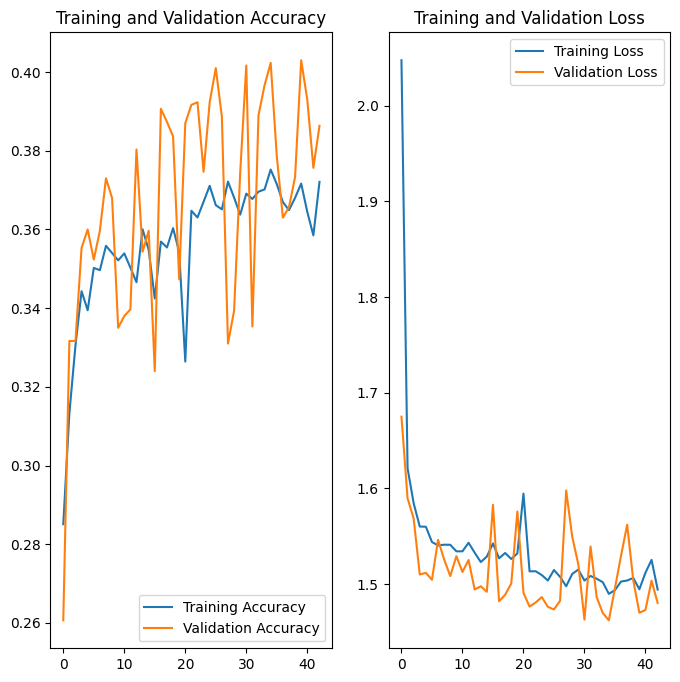

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Modelo convolucional

In [19]:
def build_model_conv(input_shape):
    i = Input(input_shape, dtype=tf.float32)

    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(8, (3, 3))(x)
    x = Activation("relu")(x)

    x = Conv2D(16, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(6)(x)
    x = Activation("softmax")(x)
    return tf.keras.Model(inputs=i, outputs=x)

In [20]:
print("Building model")
conv_model = build_model_conv(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

conv_model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model


In [21]:
conv_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 150, 150, 3)       0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 150, 150, 3)       0         
                                                                 
 random_translation_1 (Rand  (None, 150, 150, 3)       0         
 omTranslation)                                                  
                                                                 
 random_contrast_1 (RandomC  (None, 150, 150, 3)       0         
 ontrast)                                                  

In [22]:
early_stopping = EarlyStopping(monitor="val_loss", patience=8, verbose=0, mode="min", restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=7, verbose=1, min_delta=1e-4, mode="min"
)

In [23]:
history_conv = conv_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=32,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/50


439/439 [==============================] - 35s 68ms/step - loss: 1.1448 - accuracy: 0.5375 - val_loss: 0.8776 - val_accuracy: 0.6697 - lr: 0.0010
Epoch 2/50
439/439 [==============================] - 28s 65ms/step - loss: 0.8597 - accuracy: 0.6698 - val_loss: 0.9307 - val_accuracy: 0.6420 - lr: 0.0010
Epoch 3/50
439/439 [==============================] - 28s 64ms/step - loss: 0.7603 - accuracy: 0.7129 - val_loss: 0.6659 - val_accuracy: 0.7623 - lr: 0.0010
Epoch 4/50
439/439 [==============================] - 28s 64ms/step - loss: 0.6875 - accuracy: 0.7401 - val_loss: 0.6833 - val_accuracy: 0.7447 - lr: 0.0010
Epoch 5/50
439/439 [==============================] - 30s 67ms/step - loss: 0.6394 - accuracy: 0.7653 - val_loss: 0.6288 - val_accuracy: 0.7680 - lr: 0.0010
Epoch 6/50
439/439 [==============================] - 30s 69ms/step - loss: 0.6077 - accuracy: 0.7724 - val_loss: 0.5893 - val_accuracy: 0.7923 - lr: 0.0010
Epoch 7/50
439/439 [==============================] - 30s 67ms/step -

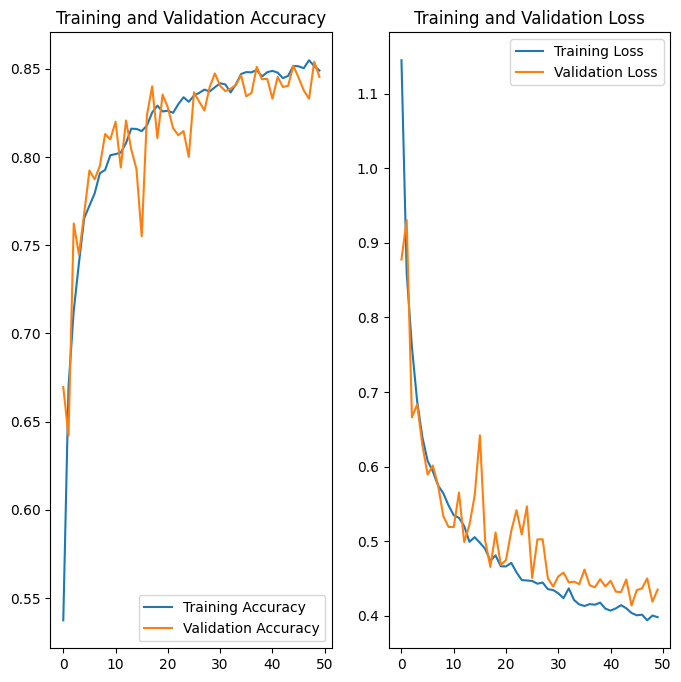

In [24]:
acc = history_conv.history['accuracy']
val_acc = history_conv.history['val_accuracy']

loss = history_conv.history['loss']
val_loss = history_conv.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 153ms/step


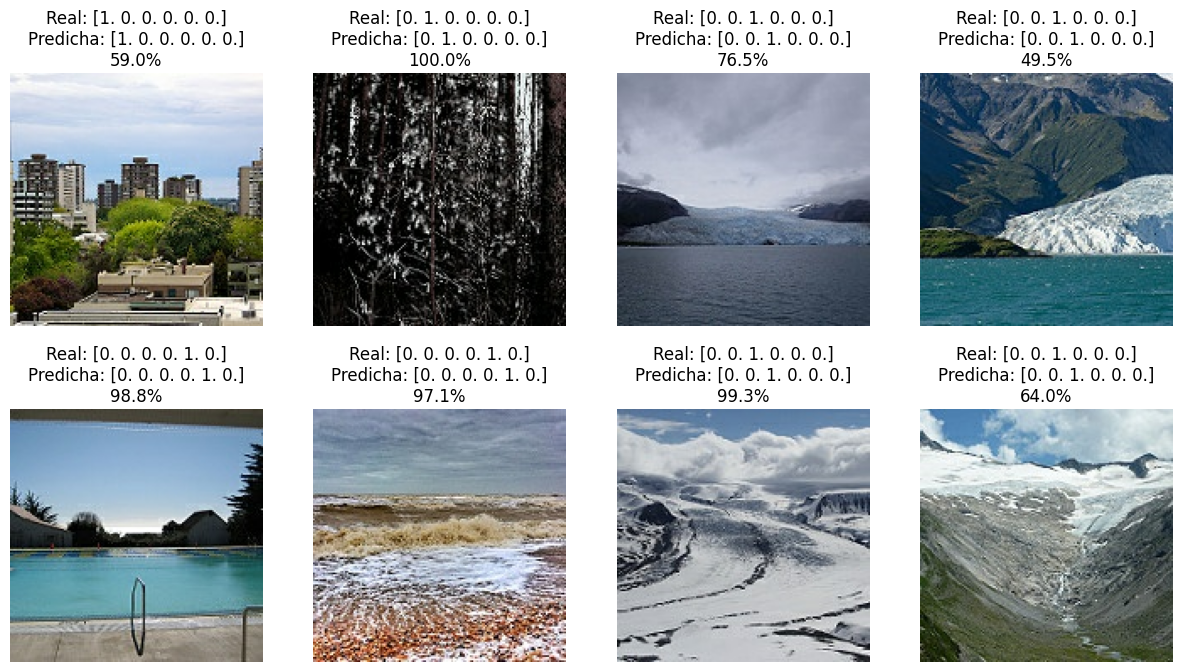

In [25]:
for images, labels in val_ds.take(1):
    preds = conv_model.predict(images)

true_classes = np.argmax(labels.numpy(), axis=1)
predicted_classes = np.argmax(preds, axis=1)

N = 8
plt.figure(figsize=(15, 8))

for i in range(N):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    confidence = np.max(preds[i])*100


    plt.title(f"Real: {labels[true_classes[i]]}\nPredicha: {labels[predicted_classes[i]]}\n{confidence:.1f}%")
    plt.axis("off")

plt.show()

## Modelo con bloques residuales

In [46]:
def puente_module(x, filters):
    conv = Conv2D(filters, (3,3), padding='same')(x)
    conv = BatchNormalization()(conv,training=True)
    conv = Activation("relu")(conv)

    conv = Conv2D(3, (1,1), padding='same')(conv)
    conv = BatchNormalization()(conv,training=True)

    conv += x
    return conv
    

In [47]:
def build_model_residual(input_shape):
    i = Input(input_shape, dtype=tf.float32)

    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = puente_module(x, 32)
    x = Activation("relu")(x)
    # x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    
    x = puente_module(x, 64)
    x = Activation("relu")(x)
    
    x = puente_module(x, 128)
    x = Activation("relu")(x)
    
    x = puente_module(x, 256)
    x = Activation("relu")(x)
    
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(6)(x)
    x = Activation("softmax")(x)
    return tf.keras.Model(inputs=i, outputs=x)

In [48]:
print("Building model")
residual_model = build_model_residual(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

residual_model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model


In [49]:
residual_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling_9 (Rescaling)     (None, 150, 150, 3)          0         ['input_10[0][0]']            
                                                                                                  
 random_flip_18 (RandomFlip  (None, 150, 150, 3)          0         ['rescaling_9[0][0]']         
 )                                                                                                
                                                                                                  
 random_flip_19 (RandomFlip  (None, 150, 150, 3)          0         ['random_flip_18[0][0]']

In [50]:
early_stopping = EarlyStopping(monitor="val_loss", patience=8, verbose=0, mode="min", restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=7, verbose=1, min_delta=1e-4, mode="min"
)

In [ ]:
history_conv = residual_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=32,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/50


2025-04-28 23:17:15.027212: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-28 23:17:15.166142: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-28 23:17:15.474057: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 847.34MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-28 23:17:15.562790: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (G

ResourceExhaustedError: Graph execution error:

Detected at node 'model_5/conv2d_36/Conv2D' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/root/.local/lib/python3.8/site-packages/ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/root/.local/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/root/.local/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/root/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "/root/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "/root/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/root/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/root/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "/root/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "/root/.local/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_558/2627651064.py", line 1, in <module>
      history_conv = residual_model.fit(
    File "/usr/local/lib/python3.8/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/usr/local/lib/python3.8/dist-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'model_5/conv2d_36/Conv2D'
OOM when allocating tensor with shape[32,256,150,150] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_5/conv2d_36/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_104858]